In [1]:
# geral
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
from itertools import product
from multiprocessing import cpu_count
from datetime import datetime
from uuid import uuid4
import joblib

# modeling
# import sktime
# from sktime.utils.load_data import load_from_tsfile_to_dataframe
# from sktime.utils.load_data import load_from_ucr_tsv_to_dataframe
# from sktime.utils.load_data import load_from_arff_to_dataframe
# from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
!pip install --upgrade sktime==0.4.1 tsfresh==0.16.0 statsmodels==0.11.1

Requirement already up-to-date: sktime==0.4.1 in /opt/conda/lib/python3.7/site-packages (0.4.1)
Requirement already up-to-date: tsfresh==0.16.0 in /opt/conda/lib/python3.7/site-packages (0.16.0)
Requirement already up-to-date: statsmodels==0.11.1 in /opt/conda/lib/python3.7/site-packages (0.11.1)


In [5]:
warnings.simplefilter("ignore")

In [6]:
SEED = 123
NJOBS = cpu_count() - 1

In [7]:
np.random.seed(SEED)

# Goal

The goal of this notebook is to compare different approaches for time series classification for solving a particular problem. In this case, we'll be using the [FordA dataset](http://www.timeseriesclassification.com/description.php?Dataset=FordA) from the [UCR Time Series archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/). 
As explained in the original page:
    
> This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination.

In particular, this notebook will focus on using two time series libraries: [sktime](https://sktime.org/) and [tsfresh](https://tsfresh.readthedocs.io/en/latest/). They provide different approaches of solving the problem, and the main goal here is to practice both.

# List of Contents
1. [Get Data](#Get-Data)
2. [First inspection](#First-inspection)
3. [Split into training and testing](#Split-into-training-and-testing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [tsfresh](#tsfresh)
5. [sktime](#sktime)
    - [Time Series Forest](#Time-Series-Forest)
    - [Random Interval Spectral Ensemble (RISE)](#Random-Interval-Spectral-Ensemble)
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Bag of SFA Symbols (BOSS)](#Bag-of-SFA-Symbols)
    - [Shapelet Transform](#Shapelet-Transform)

# Utility Functions

In [8]:
def fname(obj):
    """Pickle object with arbitrary date, name and uuid."""
    _human_time = datetime.now().strftime('%Y%m%d')
    _id = uuid4().hex
    _name = obj.__class__.__name__
    return f"{_human_time}_{_name}_{_id}"

In [9]:
def to_stacked(df):
    """Reshapes DataFrame of shape (n observations, t timepoints)
    into a stacked format of (n observations * t_timepoints, 3),
    the new columns being `id`, `time` and `value`"""
    
    df.index.name = 'id'
    
    return (df
            .reset_index()
            .melt(id_vars='id', var_name='ts', value_name='value'))

# Get Data

There are some intermediate steps hidden here, that for now will be left missing.

In [10]:
DATA_PATH = '../data/extracted'

In [11]:
data = pd.read_csv(os.path.join(DATA_PATH, "FordA_TRAIN.csv.gz"))
data = data.iloc[:, :-1]

# First inspection

In [12]:
data.head()

,class,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [13]:
data.shape

(3601, 501)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, class to 499
dtypes: float64(501)
memory usage: 13.8 MB


Looking at the distribution per time series and some statistics for 20 random samples:

In [15]:
rand_samples = np.random.choice(data.drop('class', axis=1).columns, 20, replace=False).astype(np.int64)

In [16]:
data.drop('class', axis=1).T.loc[:, rand_samples].describe().applymap(lambda x: format(x, '.4f'))

,229,337,327,416,306,131,5,431,434,134,276,264,34,274,489,11,378,467,425,241
count,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000
mean,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-2.8641,-2.6380,-2.7438,-2.3378,-2.2444,-2.3889,-2.9151,-2.8896,-2.7522,-3.0703,-2.8491,-2.1923,-2.7256,-2.4706,-2.2997,-2.4740,-2.9423,-2.9705,-2.7223,-2.9208
25%,-0.6133,-0.7421,-0.6525,-0.6888,-0.8097,-0.7287,-0.6099,-0.6555,-0.6868,-0.5734,-0.6374,-0.7313,-0.5959,-0.7414,-0.6726,-0.7214,-0.7889,-0.7264,-0.7565,-0.6618
50%,0.0303,0.0392,0.0182,-0.0400,-0.0303,0.0156,-0.0159,-0.0090,-0.0480,-0.0011,0.0115,-0.0811,0.0047,-0.0700,0.0122,0.0842,0.0142,0.0567,-0.0091,-0.0738
75%,0.6035,0.7164,0.6762,0.7614,0.7994,0.7222,0.7117,0.7253,0.6902,0.6414,0.6250,0.7885,0.5081,0.7446,0.7052,0.7322,0.8170,0.6477,0.7007,0.6926
max,3.3097,2.4817,2.7518,2.6318,2.1216,2.4745,2.6409,2.3659,2.7259,2.4078,3.0565,2.3932,3.2520,2.6191,2.7252,2.8135,2.0298,2.3556,2.7359,2.2830


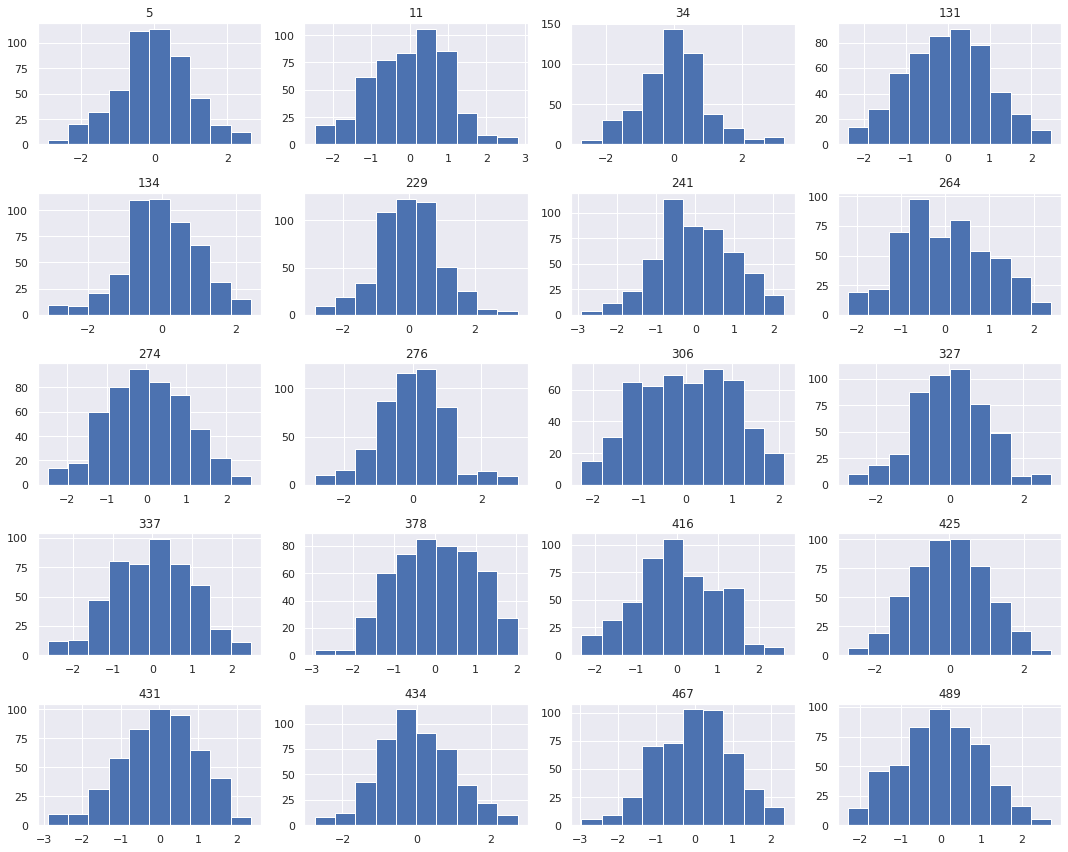

In [17]:
axs = data.drop('class', axis=1).T.loc[:, rand_samples].hist(figsize=(15, 12), layout=(5,4))
plt.tight_layout()
plt.show()

1. Descriptive statistics suggest has been previously standard scaled (mean=0 and standard deviaton = 1). This woudl explain why the data appears to range between -3 and 3.
2. Nonetheless, distribution of data for some observations is not normal.

# Split into training and testing

Before digging deeper, let's split data into training and testing to avoid leaking information in any way.

In [18]:
data.head()

,class,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [19]:
data_X = data.drop('class', axis=1)
data_y = data['class']

In [20]:
from sktime.utils.data_container import detabularize

In [21]:
train_X, test_X, train_y, test_y = (
    train_test_split(data_X, data_y, stratify=data_y,
                     shuffle=True, random_state=SEED)
)

# Exploratory Data Analysis

**Class Distribution**

In [22]:
pd.concat([train_y.value_counts().rename('count'),
           train_y.value_counts(normalize=True).rename('percent')], axis=1)

,count,percent
-1.0,1384,0.512593
1.0,1316,0.487407


Data is fairly balanced.

**Missing and error**

As explained on the source page of the dataset, data consists of 3601 time series, each with 500 time points or measurements (columns 0 to 499), and a classification target.

In [23]:
data.drop('class', axis=1).isna().sum().sum()

0

All time series have the same number of measurements with no missing data.

**Visualization**

For visualization purposes, it's usually easier to deal with data in a "melted", also called stacked or long, format:

In [24]:
train_X_melt = (train_X
               .reset_index()
               .melt(id_vars='index', var_name='ts', value_name='value')
               .set_index(['index', 'ts']))
train_X_melt.head()

,,value
index,ts,
2752,0,1.790104
421,0,-0.197966
505,0,-0.769559
694,0,0.940676
1140,0,0.166898


In [25]:
# sampling positive and negative classes for inspection
idx_positive = train_y[train_y == 1].index.values
idx_negative = train_y[train_y == -1].index.values

n_samples = 10
random_positive_idx = np.random.choice(idx_positive, size=n_samples, replace=False)
random_negative_idx = np.random.choice(idx_negative, size=n_samples, replace=False)

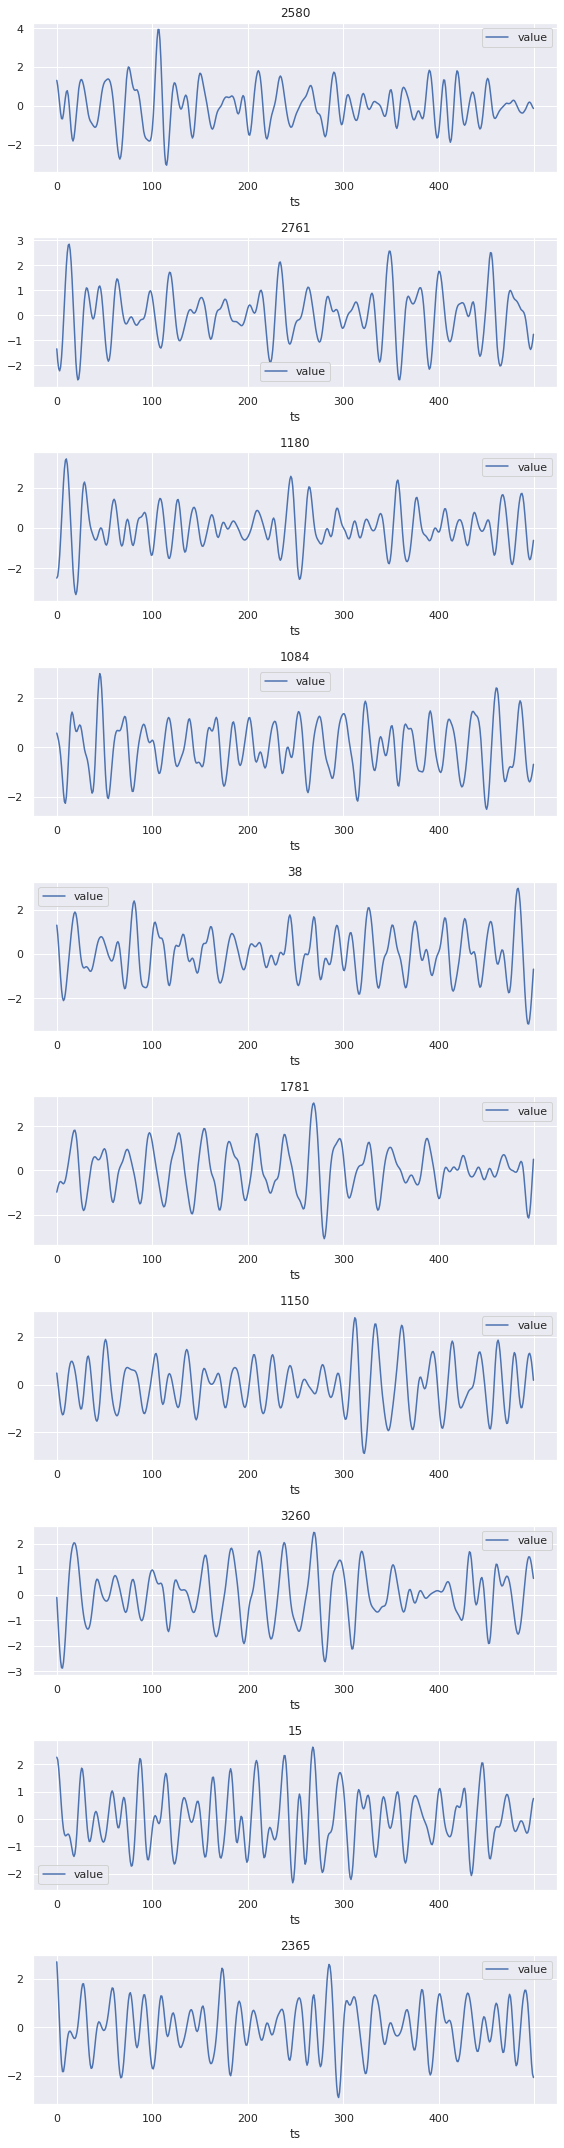

In [26]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_positive_idx):
    train_X_melt.loc[idx].plot(ax=axs[i])
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

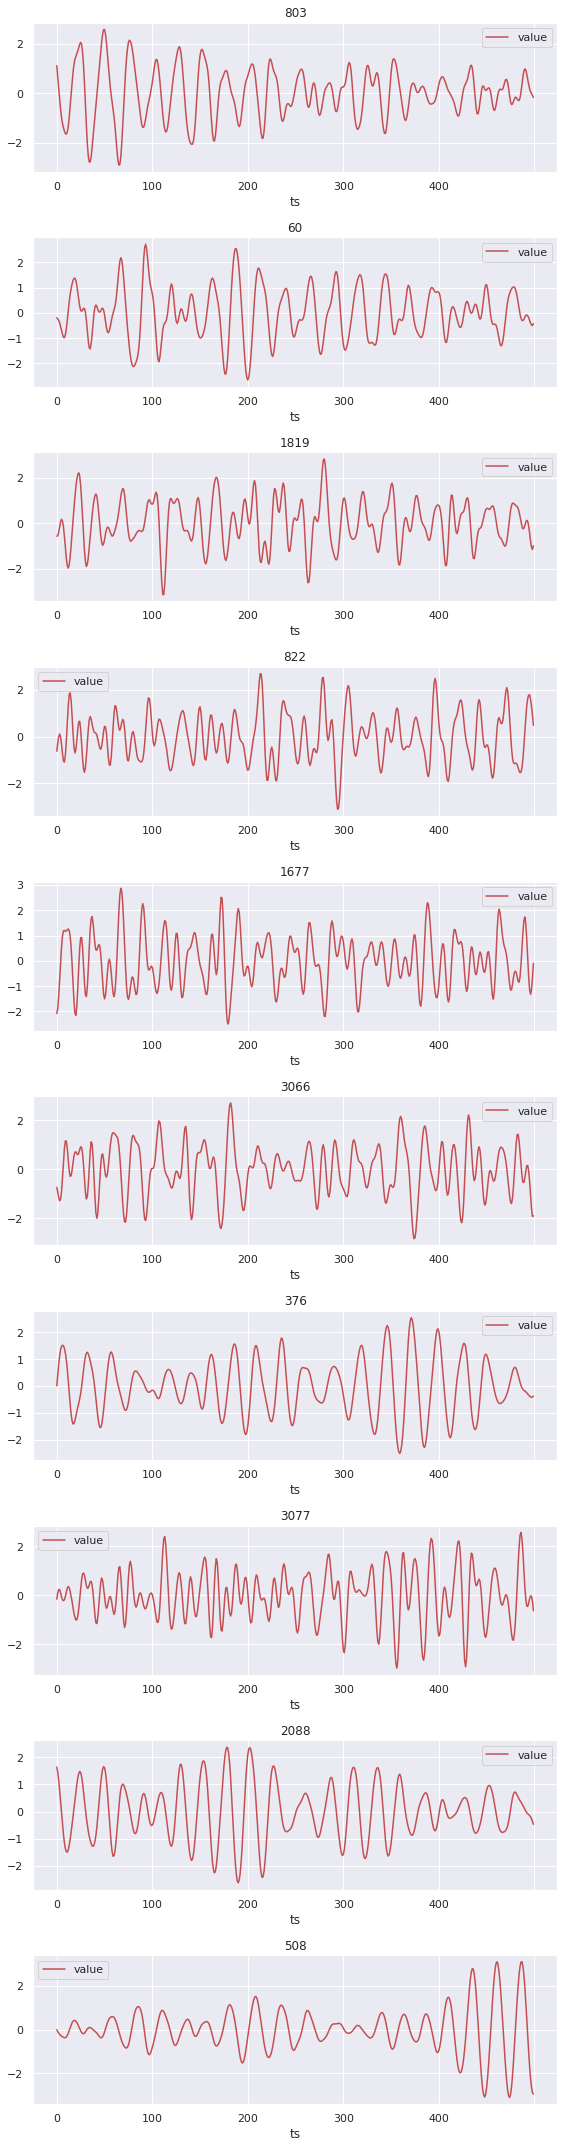

In [27]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_negative_idx):
    train_X_melt.loc[idx].plot(ax=axs[i], c='r')
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

And in terms of distribution, now looking at all of the points in positive and negative classes.

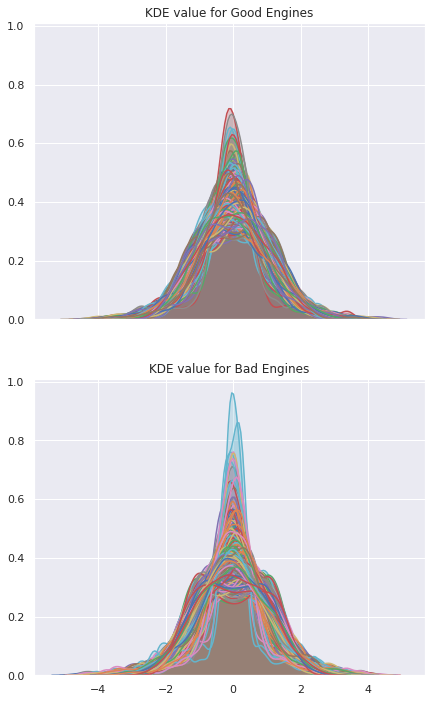

In [28]:
f, axs = plt.subplots(figsize=(7, 12), nrows=2,
                      sharex=True, sharey=True)
for idx in idx_positive:
    sns.distplot(train_X_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[0])
    axs[0].set_title('KDE value for Good Engines')

for idx in idx_negative:
    sns.distplot(train_X_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[1])
    axs[1].set_title('KDE value for Bad Engines')

plt.show()

**From the graphs**
From this small sample (10 for each class):
- the time series plot doesn't seem to provide an imediate tip as to what contributes for each classification (maybe for a trained specilist it does)
- the kernel density estimation plot seems to show that the distribution for the negative class is somewhat less normal, with some examples being actually bimodal

**Warning**

Change the data format to sktime modeling

In [29]:
# X = detabularize(data_X)
# y = data_y

X = detabularize(data.drop('class', axis=1))#.head(n=100)
y = data['class']#.head(n=100)

assert (X.index == y.index).all()

**Split into training and testing**

In [30]:
train_X, test_X, train_y, test_y = (
    train_test_split(X, y, stratify=y,
                     shuffle=True, random_state=SEED)
)

# tsfresh

`tsfresh`, Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests, is a Python library useful for extracting and selecting features from timeseries data, essentially turning a timeseries with _t_ time points into _n_ features. It's built using Dask, a python library for parallel and distributed computing. This means you can distribute the tasks of extraction and selection across clusters for highly parallelized work, and that even in a single node, tasks can be sent to different cores for faster computations. This is particularly relevant because this library allows you to use its 72 feature calculations, according to their [lisf ot calculated features page](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) at the time of creation of this notebook. These functions, depending on the settings, may yield hundreds of features for a single timeseries. Read more in their [docs page](https://tsfresh.readthedocs.io/en/latest/index.html).

This is one of the approaches for solving the problem that will be displayed here: extracting relevant features from each time series as a whole.

**Note** This library also allows for sliding window creation and computation, but this approach won't be presented in the current notebook.

Necessary imports (made here instead of header for proximity with code and easier check)

In [31]:
from sktime.transformers.series_as_features.summarize import \
    TSFreshFeatureExtractor, TSFreshRelevantFeatureExtractor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import joblib
import numpy as np

In [32]:
ts_augmenter_pipeline = Pipeline([
    ('augmenter', TSFreshRelevantFeatureExtractor(default_fc_parameters='efficient',
                                          show_warnings=False, n_jobs=NJOBS, disable_progressbar=True)),
    ('scaler', MaxAbsScaler()),
#     ('reduce_dim', PCA(n_components=5)),
    ('clf', RandomForestClassifier(n_jobs=NJOBS))
], verbose=True)

In [33]:
train_X.head()

,0
2752,0 1.790104 1 2.057403 2 2.21014...
421,0 -0.197966 1 -0.052246 2 0.00833...
505,0 -0.769559 1 -0.754554 2 -0.66431...
694,0 0.940676 1 0.856837 2 0.70652...
1140,0 0.166898 1 0.201026 2 0.25345...


In [34]:
import tsfresh
ts_augmenter_pipeline.fit(train_X, train_y)

[Pipeline] ......... (step 1 of 3) Processing augmenter, total=14.3min
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s


Pipeline(steps=[('augmenter',
                 TSFreshRelevantFeatureExtractor(disable_progressbar=True,
                                                 n_jobs=3,
                                                 show_warnings=False)),
                ('scaler', MaxAbsScaler()),
                ('clf', RandomForestClassifier(n_jobs=3))],
         verbose=True)

In [39]:
!mkdir ../models
joblib.dump(ts_augmenter_pipeline, os.path.join('../models', f"{fname(ts_augmenter_pipeline)}.joblib"))

['../models/20201014_Pipeline_b5bd7040b3054119b49ef0454ae55dc0.joblib']

In [35]:
pred_y = ts_augmenter_pipeline.predict(test_X)

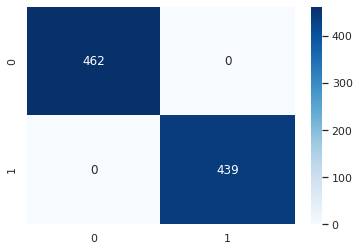

In [36]:
sns.heatmap(confusion_matrix(test_y, pred_y),
            cmap='Blues', annot=True, fmt='.0f');

In [37]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       462
         1.0       1.00      1.00      1.00       439

    accuracy                           1.00       901
   macro avg       1.00      1.00      1.00       901
weighted avg       1.00      1.00      1.00       901



# sktime

**Get Data in adequate format**

In [ ]:
from sktime.utils.data_container import detabularize

In [ ]:
X = detabularize(data_X)
y = data_y

In [ ]:
assert (X.index == y.index).all()

**Split into training and testing**

In [ ]:
train_X, test_X, train_y, test_y = (
    train_test_split(X, y, stratify=y,
                     shuffle=True, random_state=SEED)
)

## Time Series Forest

[List of Contents](#List-of-Contents)

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sktime.series_as_features.compose import FeatureUnion
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor
from sktime.transformers.series_as_features.segment import RandomIntervalSegmenter
from sktime.transformers.series_as_features.compose import RowTransformer
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.utils.time_series import time_series_slope
from sklearn.model_selection import cross_validate

In [ ]:
segmenter = RandomIntervalSegmenter(n_intervals='sqrt', random_state=SEED)
transformer = FeatureUnion([
    ('mean', RowTransformer(FunctionTransformer(func=np.mean, validate=False))),
    ('std', RowTransformer(FunctionTransformer(func=np.std, validate=False))),
    ('slope', RowTransformer(FunctionTransformer(func=time_series_slope, validate=False)))
])
classifier = DecisionTreeClassifier()
steps = [
    ('segment', segmenter),
    ('transform', transformer),
    ('clf', classifier)
]

time_series_tree = Pipeline(steps)

Inspecting 1st step output:

In [ ]:
train_X_subseq = segmenter.fit_transform(train_X)
type(train_X_subseq)

In [ ]:
train_X_subseq

Then, the original timeseries features (time series in each row) are now transformed into 22 features that correspond to subsequences of the original "raw" timeseries ones.

`(n_observations, 1) -> (n_observations, p_subset_timseries_features)`

Now applying the `RowTransformer` object to extract features from each subset of feaures.

In [ ]:
train_X_subseq_transf = transformer.fit_transform(train_X_subseq)
print(type(train_X_subseq_transf))
print(train_X_subseq_transf.shape)
train_X_subseq_transf.head()

As we've passed 22 timeseries_subsequences as features, and requested the object to compute 3 calculations over each (mean, std, slope), it follows that we get now 66 (22 * 3) columns.

**Notice** how now they are values as features (not anymore timeseries subsequences as features).

Now these features are in a common ML format: (_n_ observations, _m_ real valued features). What follows is the classification training with a common ML algortihm. 

In [ ]:
# fit ML algorithm
classifier.fit(train_X_subseq_transf, train_y)

# compute training predictions
preds = classifier.predict(train_X_subseq_transf)
preds

We can (and should) also use cross-validation for a more complete evaluation:

In [ ]:
cv_results = cross_validate(classifier, train_X_subseq_transf, train_y,
                            cv=10, n_jobs=NJOBS,
                            scoring=['recall', 'precision', 'f1'])

In [ ]:
print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

However that is for a single tree. `TimeSeriesForestClassifier` extends this processes for many trees with bootstrapped samples of random intervals:

In [ ]:
steps = [
    ('segmenter', segmenter),
    ('transformer', transformer),
    ('clf', classifier)
]
time_series_tree = Pipeline(steps)

tsf = TimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=50,
    criterion='entropy',
    bootstrap=True,
    oob_score=True,
    random_state=SEED,
    n_jobs=NJOBS
)

In [ ]:
cv_results = cross_validate(tsf, train_X, train_y,
                            cv=5, n_jobs=NJOBS,
                            scoring=['recall', 'precision', 'f1'])

print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

WOW! Now a huge increment from the first approach tried (with features extracted/calculated from the entire time series).

## Random Interval Spectral Ensemble

[List of Contents](#List-of-Contents)

Works similarly as te precious example, only we substitute regular statistical fetures to series-to-series features. For example;
- Fitted auto-regressive coefficients,
- Estimated autocorrelation coefficients,
- Power spectrum coefficients.


**Note** This requires that a new step is added: we now need to tabularise the data after the transformation

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from sktime.transformers.series_as_features.reduce import Tabularizer
from sktime.series_as_features.compose import FeatureUnion
from sktime.utils.data_container import tabularize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
def ar_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    lags = np.minimum(len(x) - 1, maxlag) // 2
    model = AutoReg(endog=x, trend="n", lags=lags)
    return model.fit().params.ravel()

def acf_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    nlags = np.minimum(len(x) - 1, maxlag)
    return acf(x, nlags=nlags, fft=True).ravel()

def powerspectrum(x):
    x = np.asarray(x).ravel()
    fft = np.fft.fft(x)
    ps = fft.real * fft.real + fft.imag * fft.imag
    return ps[:ps.shape[0] // 2].ravel()

In [ ]:
# 1st step: breaking time series data into 
# random interval (of fixed length)
segmenter = RandomIntervalSegmenter(n_intervals='sqrt', min_length=5, random_state=SEED)

# 2nd step the transformer
row_ar_coefs = ('ar', RowTransformer(FunctionTransformer(func=ar_coefs, validate=False)))
row_acf_coefs = ('acf', RowTransformer(FunctionTransformer(func=acf_coefs, validate=False)))
row_ps = ('ps', RowTransformer(FunctionTransformer(func=powerspectrum, validate=False)))
ser_to_ser_transf_steps = [row_ar_coefs, row_acf_coefs, row_ps]
ser_to_ser_transformer = Pipeline([('feature_union', FeatureUnion(ser_to_ser_transf_steps))])

# 3rd step: series to real-valued feature transformer
tabularizer = Pipeline([('tabularize', Tabularizer())])

# 3rd step learning algorithm
classifier = DecisionTreeClassifier()

Just as before, step by step:

In [ ]:
train_X_detab_subseq = segmenter.fit_transform(train_X_detab)
type(train_X_detab_subseq)

In [ ]:
train_X_detab_subseq

In [ ]:
for i, c in enumerate(train_X_detab_subseq.columns):
    print(f'Feature {i} is a time series subsequence of length {len(train_X_detab_subseq.loc[0, c])}')

As before, from a single feature column containing an entire time series (timeseries as feature approach), the `RandomIntervalSegmenter` extracts number of subsequences of that time series feature (22, in this case).


Following, we apply row transformations in order to extract the features:

In [ ]:
train_X_detab_subseq_transf = ser_to_ser_transformer.fit_transform(train_X_detab_subseq)

And we verify that each "cell" of the DataFrame is still a time series subsequence:

In [ ]:
print(type(train_X_detab_subseq_transf))
print(train_X_detab_subseq_transf.shape)
for i in range(len(train_X_detab_subseq_transf.columns)):
    print(f'Transformed feature {i} is a time series subsequence of length {len(train_X_detab_subseq_transf.iloc[0, i])}')

Hence, the need to tabularie it (from time series as features to tabular ML format).

In [ ]:
train_X_detab_subseq_transf_tab = tabularizer.fit_transform(train_X_detab_subseq_transf)

In [ ]:
print(train_X_detab_subseq_transf_tab.shape)

In [ ]:
train_X_detab_subseq_transf_tab.head(20)

Each instance (row) has 4558 real-valued features, each extracted from the subsequence time series calcuations (which in turn were computed from the "raw" subsequence time series features). Something like:

```
(n , 1): observations x "raw" timeseries as features)
    |
    v
(n , 22): observations x "raw" subsequence timeseries as features)
    |
    v
(n , 66): observations x transf. timeseries features)
    |
    v
(n , 4558): observations x real-valued features calculated from transf. timeseries features
```

Finally, now we are capable of applying the ML algorithm, in this case a decision tree:

In [ ]:
# fit ML algorithm
classifier.fit(train_X_detab_subseq_transf_tab, train_y)

# compute training predictions
preds = classifier.predict(train_X_detab_subseq_transf_tab)
preds

We can (and should) also use cross-validation for a more complete evaluation:

In [ ]:
cv_results = cross_validate(classifier, train_X_detab_subseq_transf_tab, train_y,
                            cv=5, n_jobs=MAX_CORES,
                            scoring=['recall', 'precision', 'f1'])

In [ ]:
print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

Extending to a forest o trees;

In [ ]:
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals=1, min_length=5)),
    ('transform', FeatureUnion([
        ('ar', RowTransformer(FunctionTransformer(func=ar_coefs, validate=False))),
        ('acf', RowTransformer(FunctionTransformer(func=acf_coefs, validate=False))),
        ('ps', RowTransformer(FunctionTransformer(func=powerspectrum, validate=False)))
    ])),
    ('tabularise', Tabularizer()),
    ('clf', DecisionTreeClassifier())
]
rise_tree = Pipeline(steps)

rise = TimeSeriesForestClassifier(estimator=rise_tree, n_estimators=20, n_jobs=MAX_CORES)
rise.fit(train_X_detab, train_y_detab)

In [ ]:
pred_y_rise_tree = rise.predict(test_X_detab)

# print classification report
print(classification_report(test_y_detab.values, pred_y_rise_tree))
# display colored confusion matrix
f = plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(test_y_detab.values, pred_y_rise_tree),
            annot=True, cmap='Blues', fmt='.0f',)
plt.show()

Still, `sktime` provides an object that does all of this within a single interface:

In [ ]:
from sktime.classification.frequency_based import RandomIntervalSpectralForest as RISE

In [ ]:
rise = RISE(n_estimators=20, random_state=SEED)
rise.fit(train_X_detab, train_y_detab)

In [ ]:
pred_y_rise = rise.predict(test_X_detab)

# print classification report
print(classification_report(test_y_detab.values, pred_y_rise))
# display colored confusion matrix
f = plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(test_y_detab.values, pred_y_rise),
            annot=True, cmap='Blues', fmt='.0f',)
plt.show()

And results are slightly worse.

# K-Nearest-Neighbors

[List of Contents](#List-of-Contents)

Now it's a distance approach (or a similarity-based approach, where distance is used as a metric of similarity).
In this case, kNN is extended to accomodate timeseries data (and timeseries as features format).

A common distance metrics in this case is the Dynamic Time Warping distance.

In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [ ]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw", )
knn.fit(train_X_detab, train_y_detab)

In [ ]:
cv_results = cross_validate(knn, train_X_detab, train_y_detab,
                            cv=5, n_jobs=MAX_CORES,
                            scoring=['recall', 'precision', 'f1'])

print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

# Bag of SFA Symbols

This approach is based on representing subsequences of the timeseries data with "words" in order to form a dictionary. Classification is then performed based on how similar are the sets of words for each class.

In [ ]:
from sktime.classification.dictionary_based import BOSSEnsemble

In [ ]:
boss_clf = BOSSEnsemble(randomised_ensemble=True, n_parameter_samples=50,
                        max_ensemble_size=50, time_limit=20, random_state=SEED)

In [ ]:
boss_clf.fit(train_X_detab, train_y_detab)

In [ ]:
boss_clf.__dict__

In [ ]:
pred_y_boss_clf = boss_clf.predict(test_X_detab)

# print classification report
print(classification_report(test_y_detab.values, pred_y_boss_clf))
# display colored confusion matrix
f = plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(test_y_detab.values, pred_y_boss_clf),
            annot=True, cmap='Blues', fmt='.0f',)
plt.show()

# Shapelet Transform

In [ ]:
from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform

In [ ]:
DATA_PATH = '../data/extracted'

In [ ]:
data = pd.read_csv(os.path.join(DATA_PATH, "FordA_TRAIN.csv.gz"))
data = data.iloc[:, :-1]

In [ ]:
data_X = detabularize(data.drop('class', axis=1))
data_y = data['class'].map(str).values

In [ ]:
train_X, test_X, train_y, test_y = (
    train_test_split(data_X, data_y, stratify=data_y,
                     shuffle=True, random_state=SEED)
)

In [ ]:
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_contract_in_mins = 60

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
TS_LEN = 500
initial_num_shapelets_per_case = 10

# reduce candidate shapelets search space
min_shapelet_length = 30
max_shapelet_length = 100

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    min_shapelet_length=min_shapelet_length,
    max_shapelet_length=max_shapelet_length,
    time_contract_in_mins=time_contract_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(train_X, train_y)

**Save model**

In [ ]:
joblib.dump(st, os.path.join('../models', f"{fname(st)}.joblib"))

**Visualize shapelets**

In [ ]:
# for each extracted shapelet (in descending order of quality/information gain)
f, axs = plt.subplots(figsize=(8, 6*len(st.shapelets)), nrows=len(st.shapelets))
for i, s in enumerate(st.shapelets):

    # plot the series that the shapelet was extracted from
    axs[i].plot(train_X.iloc[s.series_id, 0], 'gray')

    # overlay the shapelet onto the full series
    axs[i].plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        train_X.iloc[s.series_id,0][s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    
    # name plot
    axs[i].set_title(f"{s}")

plt.tight_layout()
plt.show()

**Evaluate Results**

In [ ]:
train_X_transf = st.transform(train_X)
train_X_transf.to_csv('../data/interim/train_shapelet_transform_20200922csv')

In [ ]:
test_X_transf = st.transform(test_X)

In [ ]:
train_X_transf.describe()

In [ ]:
train_X_transf.hist(figsize=(2*4,3*4), layout=(3,2));

In [ ]:
rf_clf = RandomForestClassifier(n_jobs=NJOBS, verbose=2)
rf_clf.fit(train_X_transf, train_y)

In [ ]:
print(classification_report(test_y, pred_y))

# print classification report
print(classification_report(test_y, pred_y))
# display colored confusion matrix
f = plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(test_y, pred_y),
            annot=True, cmap='Blues', fmt='.0f',)
plt.show()